ENGS 106 - Final Project
Authors - Taka Khoo, Doruk, Harry Leiter

<small>


             

    Overall design:

        typedef struct {
            image
            label
        } sample_t


        training(){
            init_network()
            sample = load_datapoint
            output = feedforward(sample->png)
            tocompare = getbackpropdata(sample)
            backprop(output, tocompare)
        }




        gettrainingdata(sample_t sample){
            Case (sample->label):
                1:
                    upscaledimg = upscale(sample->image)
                    gaussian = gaussian(upscaledimg)
                    harmonics = harmonics(gaussian, sample->fundamental_note_for_A_in_hertz)
                    harmonics_smear = gaussian(harmonics)
                    smooth = smooth(harmonics_smear)
                    return trainingcomparison       
                2:
                .
                .
                .
        
        }

        Still need to do init, feedforward, backprop pseudocode
</small>

# Below this markdown are an idea of the functions we could use to condition our data for the purposes of comparison during training

and here is my thinking behind these functions

<small> Create neural network Structure
    - inputs will be numbers 0-7 of mnist dataset (pictures of handwritten digits from 0-7)
        -These inputs will represent the notes of the major scale
    - output
        *Image of a spectrogram
            *Want to look like the input image? (maybe this would allow for more creative experimentation with finalized model than just looking like a letter)
            
            *Image is square, so we would want the output to be square as well
                -For a spotify-quality spectrogram 24 seconds long:
                    1024x1024 resolution
                    *Could go shorter, but it would make the comparison training part more difficult to train

                    ~Training on 1024x1024 input images would probably be too resource intensive, so we might want to
                     upscale input image and then compare to that

                    *maybe drop down to 1008 for easier upscaling (mnist - 24x24 -- 24*36 = 1008 {24*4*3*3} -- esrgan upscaler works in factors of 1,2,3,4 )

            *We could compare the images with readily available tools online

            *In natural musical instruments, harmonics typically die out the further one gets from the fundamental note. Maybe we can
             achieve this by applying a horizontal gaussian filter to the output, and using that to determine loss as well
</small>

In [252]:
%pip install numpy
%pip install scipy
%pip install matplotlib
%pip install torch
%pip install torchaudio
%pip install torchvision
%pip install numpy
%pip install Pillow
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Upscaler:

In [253]:
def upscale(input):
    !cd Upscaler && chmod u+x realesrgan-ncnn-vulkan && ./realesrgan-ncnn-vulkan -i ../{input}.jpg -o ../{input}-upscaled.png -s 3 && ./realesrgan-ncnn-vulkan -i ../{input}-upscaled.png -o ../{input}-upscaled.png -s 3 && ./realesrgan-ncnn-vulkan -i ../{input}-upscaled.png -o ../{input}-upscaled.png -s 4

upscale('thenumber4')
upscale('thenumber5')

[0 NVIDIA GeForce RTX 3090]  queueC=2[8]  queueG=0[16]  queueT=1[2]
[0 NVIDIA GeForce RTX 3090]  bugsbn1=0  bugbilz=0  bugcopc=0  bugihfa=0
[0 NVIDIA GeForce RTX 3090]  fp16-p/s/a=1/1/1  int8-p/s/a=1/1/1
[0 NVIDIA GeForce RTX 3090]  subgroup=32  basic=1  vote=1  ballot=1  shuffle=1
[1 Intel(R) UHD Graphics 770 (ADL-S GT1)]  queueC=0[1]  queueG=0[1]  queueT=0[1]
[1 Intel(R) UHD Graphics 770 (ADL-S GT1)]  bugsbn1=0  bugbilz=0  bugcopc=0  bugihfa=0
[1 Intel(R) UHD Graphics 770 (ADL-S GT1)]  fp16-p/s/a=1/1/1  int8-p/s/a=1/1/1
[1 Intel(R) UHD Graphics 770 (ADL-S GT1)]  subgroup=32  basic=1  vote=1  ballot=1  shuffle=1
[2 llvmpipe (LLVM 17.0.6, 256 bits)]  queueC=0[1]  queueG=0[1]  queueT=0[1]
[2 llvmpipe (LLVM 17.0.6, 256 bits)]  bugsbn1=0  bugbilz=0  bugcopc=0  bugihfa=0
[2 llvmpipe (LLVM 17.0.6, 256 bits)]  fp16-p/s/a=1/1/1  int8-p/s/a=1/1/1
[2 llvmpipe (LLVM 17.0.6, 256 bits)]  subgroup=8  basic=1  vote=1  ballot=1  shuffle=1
0.00%
[0 NVIDIA GeForce RTX 3090]  queueC=2[8]  queueG=0[16]  

In [254]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter
from PIL import Image
import matplotlib.pyplot as plt


* Gaussian function:

In [255]:
'''
                        This function turns the images vertical axis into a gaussian distribution
'''
def gaussian(image, sigma):

    blurred = gaussian_filter1d(image, sigma=sigma, axis=0)
    return blurred

Applying vertical gaussian to images

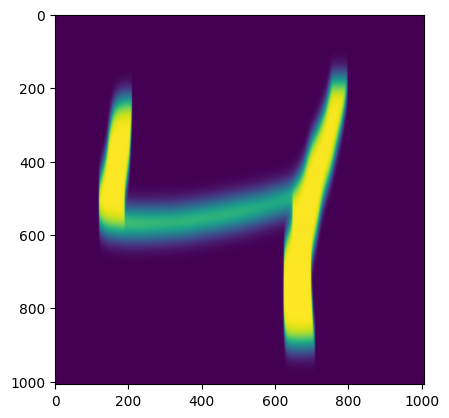

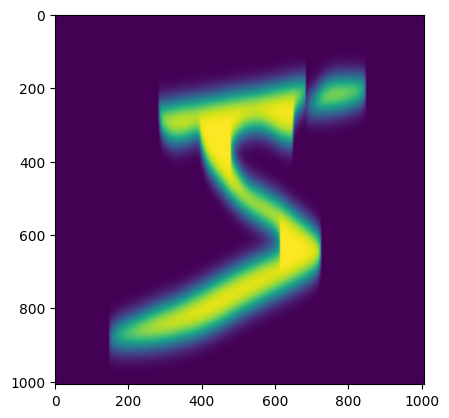

In [256]:
'''
                                            Passing 4 and 5 through gaussian
'''
sd = 30 #sd for vertical gaussian

image = Image.open('thenumber4-upscaled.png').convert('L') #For 4
blurred = gaussian(image, sd)
plt.imshow(blurred)
plt.show()
im = Image.fromarray(blurred).convert('RGB')
im.save("thenumber4-upscaled-blurred.png")
np.save('thenumber4-upscaled-blurred', blurred)

image = Image.open('thenumber5-upscaled.png').convert('L') #For 5
blurred = gaussian(image, sd)
plt.imshow(blurred)
plt.show()
im = Image.fromarray(blurred).convert('RGB')
im.save("thenumber5-upscaled-blurred.png")
np.save('thenumber5-upscaled-blurred', blurred)


Harmonics Extraction:

In [257]:
'''
                            This function extracts the harmonics
'''
def harmonics(gaussian, fundamentalnote):
    harmonicsarray = np.zeros((1008,1008))
    for column in range(1008):
        for row in range(1008):
            if(row % fundamentalnote == 0):
                harmonicsarray[row, column] = gaussian[row, column]
            else:
                harmonicsarray[row, column] = 0
    return harmonicsarray

Applying to Gaussians (4,5)

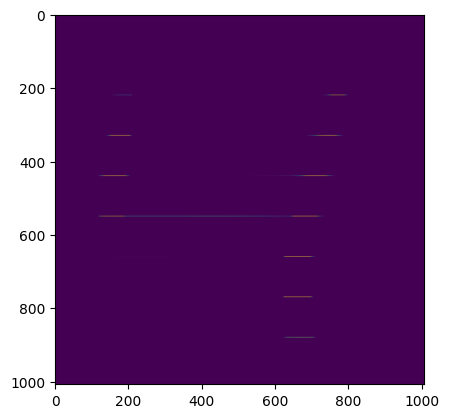

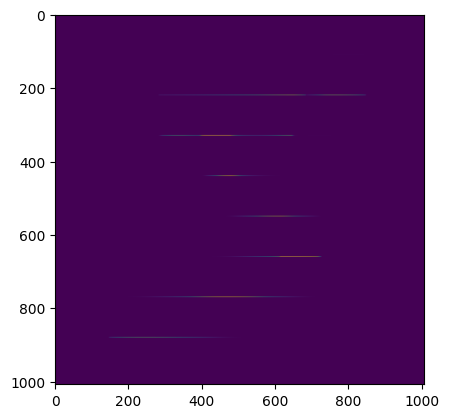

In [258]:
gaussiann = np.load('thenumber4-upscaled-blurred.npy')
harmonic = harmonics(gaussiann, 110)

plt.imshow(harmonic)
plt.show()
im = Image.fromarray(harmonic).convert('RGB')
im.save("thenumber4-upscaled-blurred-harmonics.png")

gaussiann = np.load('thenumber5-upscaled-blurred.npy')
harmonic = harmonics(gaussiann, 110)

plt.imshow(harmonic)
plt.show()
im = Image.fromarray(harmonic).convert('RGB')
im.save("thenumber5-upscaled-blurred-harmonics.png")

Second Gaussian (4,5)

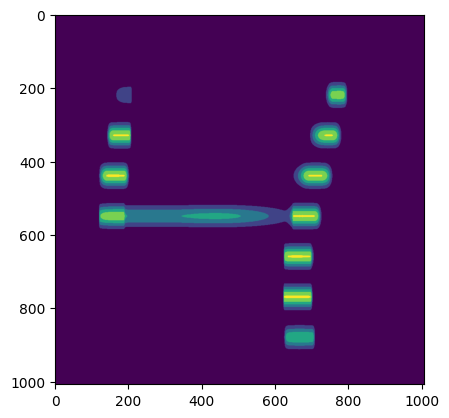

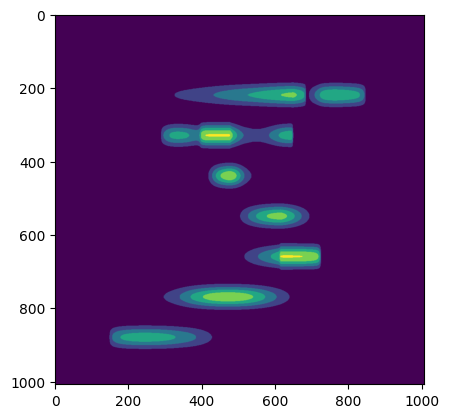

In [259]:
'''
                    Noticed this is very sparse ^, I'm going to apply another gaussian to the harmonics
'''
#for 4
smear = 20
image = Image.open('thenumber4-upscaled-blurred-harmonics.png').convert('L')
secondgaussian = gaussian(image, smear)
im = Image.fromarray(secondgaussian).convert('RGB')
#Normalize
secondgaussian1 = (secondgaussian - secondgaussian.min()) / (secondgaussian.max() - secondgaussian.min()) * 255
im.save("thenumber4-upscaled-blurred-harmonics-smeared.png")

plt.imshow(secondgaussian1)
plt.show()

#for 5
smear = 20
image = Image.open('thenumber5-upscaled-blurred-harmonics.png').convert('L')
secondgaussian = gaussian(image, smear)
im = Image.fromarray(secondgaussian).convert('RGB')
#Normalize
secondgaussian2 = (secondgaussian - secondgaussian.min()) / (secondgaussian.max() - secondgaussian.min()) * 255
im.save("thenumber5-upscaled-blurred-harmonics-smeared.png")

plt.imshow(secondgaussian2)
plt.show()
#Better, but now the gradient isnt smooth

Smoothing function

In [260]:
def smooth(image, sigma):
    image = gaussian_filter(image, sigma=sigma)
    return image

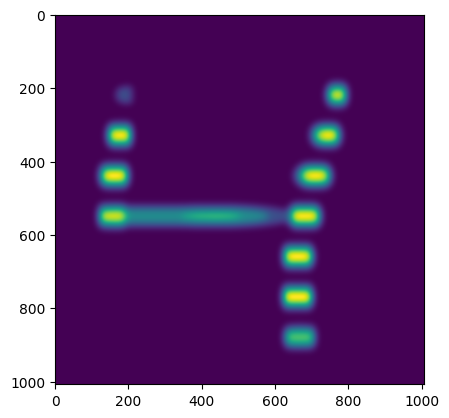

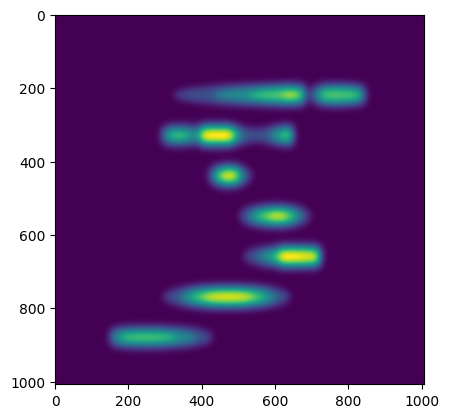

In [265]:
smooth_ = 10

#for 4
smoothed = smooth(secondgaussian1, smooth_)
#Normalize
smoothed = (smoothed  - smoothed.min()) / (smoothed.max() - smoothed.min()) * 255
plt.imshow(smoothed)
plt.show()
im = Image.fromarray(smoothed).convert('RGB')
im.save("thenumber4-upscaled-blurred-harmonics-smeared-smoothed.png")

#for 5
smoothed = smooth(secondgaussian2, smooth_)
#Normalize
smoothed = (smoothed  - smoothed.min()) / (smoothed.max() - smoothed.min()) * 255
plt.imshow(smoothed)
plt.show()
im = Image.fromarray(smoothed).convert('RGB')
im.save("thenumber5-upscaled-blurred-harmonics-smeared-smoothed.png")




* Neural Network Image Comparison
    - Probably don't want to use this one, gives very similar results for 5 and 4
    - Basically says if the "vibe" is the same, which isnt really what we want

In [272]:
#ripped from geeksforgeeks
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the last classification layer

def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path)
    img = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img

def cosine_similarity(featureA, featureB):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    return cos(featureA, featureB)

# Load and preprocess images
imageA = preprocess_image('thenumber5-upscaled-blurred-harmonics-smeared-smoothed.png')
imageB = preprocess_image('thenumber4-upscaled-blurred-harmonics-smeared-smoothed.png')
# Extract features
with torch.no_grad():
    featuresA = model(imageA)
    featuresB = model(imageB)

# Compare using cosine similarity
similarity1 = cosine_similarity(featuresA, featuresB)
print(f"Cosine Similarity (4-5): {similarity1.item()}")


Cosine Similarity (4-5): 0.9963663220405579


* MSE Image Comparison - 
    * Registers 4 and 5 as quite dissimilar which is good
    * Does not consider the structures in the image though, essentiall just a pixel-to-pixel similarity count

In [274]:
#ripped from geeksforgeeks
import cv2
import numpy as np

def mse(imageA, imageB):
    # Ensure the images have the same size
    assert imageA.shape == imageB.shape, "Images must be the same size."
    
    # Calculate the MSE between the images
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    return err

# Load images
imageA = cv2.imread('thenumber5-upscaled-blurred-harmonics-smeared-smoothed.png', cv2.IMREAD_GRAYSCALE)
imageB = cv2.imread('thenumber4-upscaled-blurred-harmonics-smeared-smoothed.png', cv2.IMREAD_GRAYSCALE)

# Compute MSE
error = mse(imageA, imageB)

print(f"Mean Squared Error (4-5): {error}")



Mean Squared Error (4-5): 2442.704371968695


* SSIM - I think this one is best
    * Analyzes lower-level structual similarity

In [276]:
#ripped from geeksforgeeks

import cv2
from skimage.metrics import structural_similarity as ssim
# Function to calculate SSIM
def calculate_ssim(imageA, imageB):
    # Convert images to grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    
    # Compute SSIM between the two images
    score, _ = ssim(grayA, grayB, full=True)
    return score

imageA = cv2.imread('thenumber4-upscaled-blurred-harmonics-smeared-smoothed.png')
imageB = cv2.imread('thenumber5-upscaled-blurred-harmonics-smeared-smoothed.png')

ssim_score = calculate_ssim(imageA, imageB)
print(f"SSIM score: {ssim_score}")

SSIM score: 0.7172541690731619
